In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

18.76210979547901
60.9111884068122
3.0


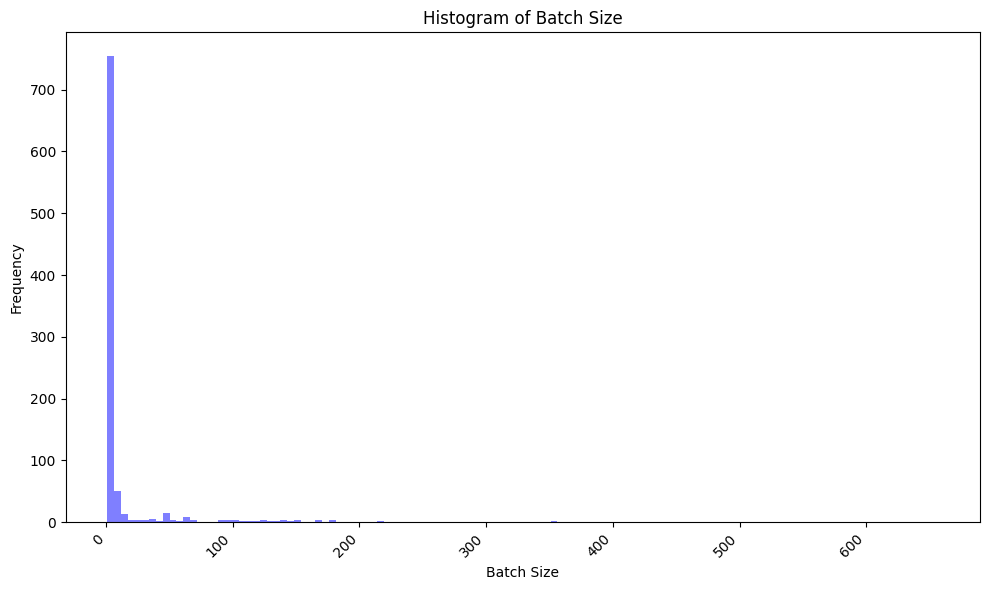

In [202]:
df = pd.read_csv("combined_15min.csv")
df = df.fillna(0)

print(df["batch_size"].mean())
print(df["batch_size"].std())
print(df["batch_size"].median())
# Ensure the batch_size column exists and contains numeric data
# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.hist(df['batch_size'], color='blue', bins=120, alpha=0.5)

# Add labels and title
plt.xlabel('Batch Size')
plt.ylabel('Frequency')
plt.title('Histogram of Batch Size')

# Rotate x-axis labels for better readability (if using timestamps)
if "ingestion_ts" in df.columns:
    plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()



In [203]:
window_size = int(df["batch_size"].mean())
num_batches = len(df) // window_size + (1 if len(df) % window_size != 0 else 0)
print(num_batches)

52


In [204]:
def z_score_anomalies(column: pd.Series) -> pd.Series:
    """
    Vectorized Z-score anomaly detection.
    Flags values with a Z-score greater than 3 or less than -3 as anomalies.
    """
    z_scores = (column - column.mean()) / column.std()
    return (z_scores > 3) | (z_scores < -3)


In [205]:
batches = []
for i in range(num_batches):
    start = i * window_size
    end = start + window_size
    batch_df = df.iloc[start:end]
    processed_batch = batch_df.copy()
    processed_batch["predicted_prices"] = z_score_anomalies(batch_df["price"])
    processed_batch["predicted_volumes"] = z_score_anomalies(batch_df["volume"])
    batches.append(processed_batch)
    
batched_df = pd.concat(batches, ignore_index=True)   

In [206]:
y_true_prices = batched_df["price_pred"]
y_pred_prices = batched_df["predicted_prices"].astype(int)

y_true_volumes = batched_df["volume_pred"]
y_pred_volumes = batched_df["predicted_volumes"].astype(int)

# Compute confusion matrices for both price and volume anomalies
conf_matrix_prices = confusion_matrix(y_true_prices, y_pred_prices)
conf_matrix_volumes = confusion_matrix(y_true_volumes, y_pred_volumes)

# Print confusion matrices
print("Confusion Matrix for Price Anomalies:")
print(conf_matrix_prices)

print("\nConfusion Matrix for Volume Anomalies:")
print(conf_matrix_volumes)

Confusion Matrix for Price Anomalies:
[[911   7]
 [ 11   0]]

Confusion Matrix for Volume Anomalies:
[[795  12]
 [102  20]]


The first row: The first value represents the number of normal records correctly predicted as normal (True Negatives), and the second represents normal records incorrectly predicted as anomalies (False Positives).

The second row: The first value represents the number of anomalous records incorrectly predicted as normal (False Negatives), and the second represents anomalous records correctly predicted as anomalies (True Positives).

In [207]:
# Calculate time differences
timestamp_format = "%Y-%m-%d %H:%M:%S.%f%z"
batched_df["trade_ts"] = batched_df["trade_ts"].apply(lambda x: datetime.strptime(x, timestamp_format))
batched_df["ingestion_ts"] = batched_df["ingestion_ts"].apply(lambda x: datetime.strptime(x, timestamp_format))

# Calculate the time to ingest (in seconds)
batched_df["time_to_ingest"] = (batched_df["ingestion_ts"] - batched_df["trade_ts"]).dt.total_seconds()


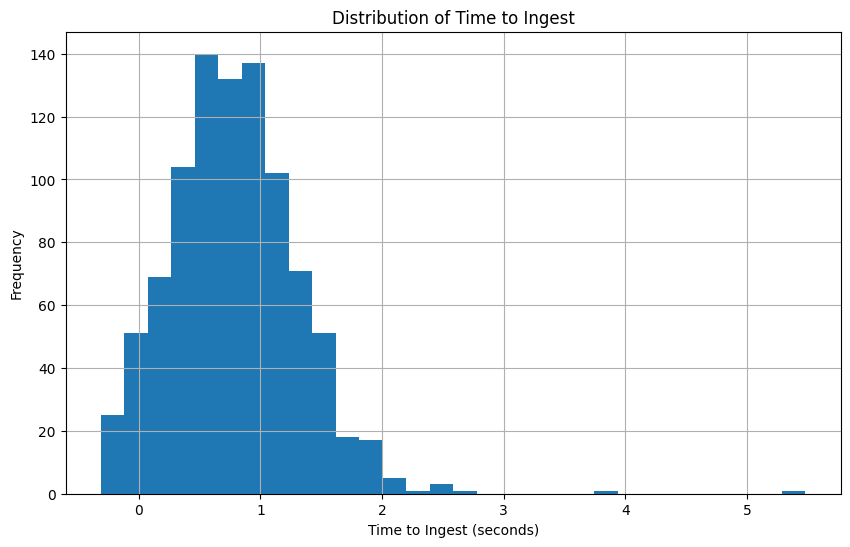

In [208]:
# Plot the time to ingest using a histogram
plt.figure(figsize=(10, 6))
plt.hist(batched_df["time_to_ingest"], bins=30)
plt.title("Distribution of Time to Ingest")
plt.xlabel("Time to Ingest (seconds)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

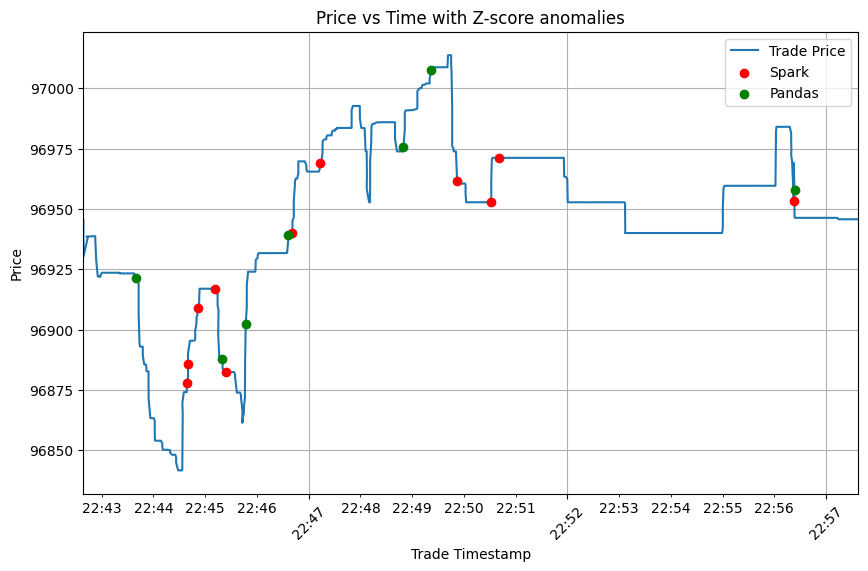

In [209]:
anomalies_df = batched_df[batched_df['price_pred'] == 1]
pandas_df = batched_df[batched_df['predicted_prices'] == 1]

y_min_value = batched_df["price"].min() * 0.9999
y_max_value = batched_df["price"].max() * 1.0001

plt.figure(figsize=(10, 6))
plt.plot(batched_df["trade_ts"], batched_df["price"], label="Trade Price")
# Plot the anomalies using red dots (or another marker)
plt.scatter(anomalies_df["trade_ts"], anomalies_df["price"], color='red', label="Spark", zorder=5)
plt.scatter(pandas_df["trade_ts"], pandas_df["price"], color='green', label="Pandas", zorder=5 )
# Adding labels and title
plt.title("Price vs Time with Z-score anomalies")
plt.xlabel("Trade Timestamp")
plt.ylabel("Price")
 
plt.xlim(batched_df["trade_ts"].min(), batched_df["trade_ts"].max())  # X-axis limits from min to max trade_ts
plt.ylim(y_min_value , y_max_value)  # Y-axis limits with a margin

# Format x-ticks to show every minute
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))  # Set ticks every 5 minutes
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format time as hour:minute
plt.gca().xaxis.set_minor_locator(mdates.MinuteLocator(interval=1))  # Set minor ticks every minute
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))  # Format minor ticks

# Rotate x-ticks for better readability
plt.xticks(rotation=45)

# Adding legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

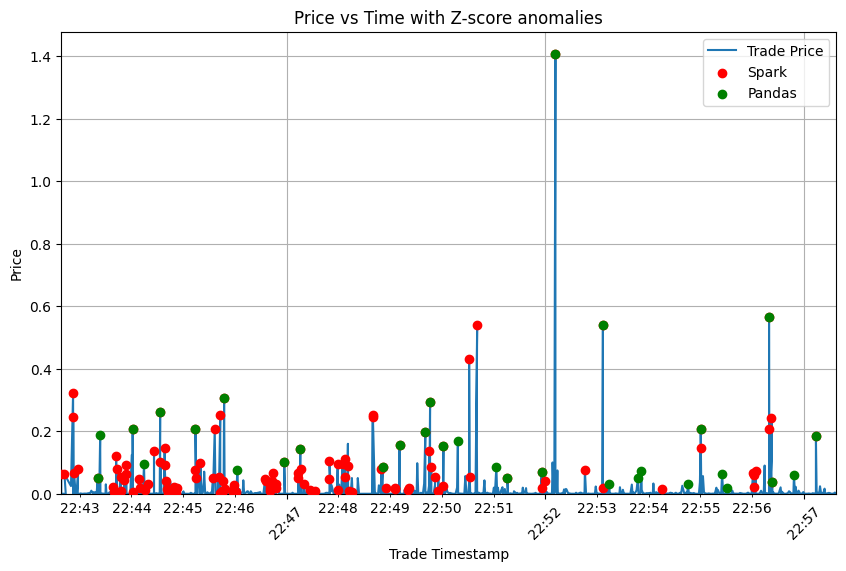

In [210]:
anomalies_df = batched_df[batched_df['volume_pred'] == 1]
pandas_df = batched_df[batched_df['predicted_volumes'] == 1]

y_min_value = 0
y_max_value = batched_df["volume"].max() * 1.05

plt.figure(figsize=(10, 6))
plt.plot(batched_df["trade_ts"], batched_df["volume"], label="Trade Price")
# Plot the anomalies using red dots (or another marker)
plt.scatter(anomalies_df["trade_ts"], anomalies_df["volume"], color='red', label="Spark", zorder=5)
plt.scatter(pandas_df["trade_ts"], pandas_df["volume"], color='green', label="Pandas", zorder=5 )
# Adding labels and title
plt.title("Price vs Time with Z-score anomalies")
plt.xlabel("Trade Timestamp")
plt.ylabel("Price")
 
plt.xlim(batched_df["trade_ts"].min(), batched_df["trade_ts"].max())  # X-axis limits from min to max trade_ts
plt.ylim(y_min_value , y_max_value)  # Y-axis limits with a margin

# Format x-ticks to show every minute
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))  # Set ticks every 5 minutes
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format time as hour:minute
plt.gca().xaxis.set_minor_locator(mdates.MinuteLocator(interval=1))  # Set minor ticks every minute
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))  # Format minor ticks

# Rotate x-ticks for better readability
plt.xticks(rotation=45)

# Adding legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()